In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#  Simulacion de las imagenes del pepperpot

En este notebook se simulan las imagenes obtenidas en el pepperpot para un potencial de extracción $V$ y una corriente $I$ en el primer solenoide.

Para el pepperpot se ha utilizado el siguiente grid:

(-30.0, 30.0)

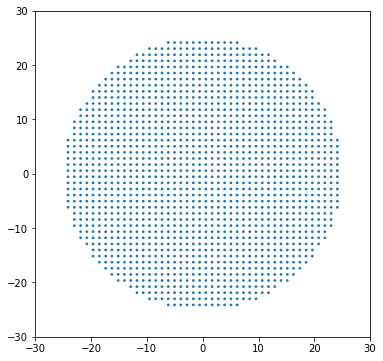

In [3]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
N=50
diam=0.5
Xs=np.linspace(-27.5,27.5,N)
Ys=np.linspace(-27.5,27.5,N)
for x in Xs:
    for y in Ys:
        if (np.sqrt(x**2+y**2)<25):
            circle=patches.Circle((x,y),diam/2)
            ax.add_patch(circle)
plt.xlim([-30,30])
plt.ylim([-30,30])


Este grid esta situado a una distancia $d1$ de la salida del primer solenoide, y la pantalla de fosforo esta a una distancia $d2$ de este grid. Cuando el haz atraviesa el primer solenoide, este se enfoca y se ha llamado $f$ a esta distancia focal (la distancia focal esta definida teniendo como origen la salida del primer solenoide).

Cuando el paz pase el grid del pepperpot los agujeros de este se proyectaran en la pantalla de fosforo, pero sus tamaños y posiciones variaran de las del grid. Si las posiciones de los centros de los agujeros son $x_0$ y $y_0$ y el diametro $\Phi_0$, y las de las proyecciones en la pantalla de fosforo $x_0'$ y $y_0'$ y $\Phi_0'$, entonces se puede calcular que:

$x_0'=(1-\frac{d2}{f-d1})x_0$, $y_0'=(1-\frac{d2}{f-d1})y_0$ y $\Phi_0'=(1-\frac{d2}{f-d1})\Phi_0$

Las distancias $d1$ y $d2$ estan fijadas en nuestro sistema.

In [4]:
d1=0.075
d2=0.035

La distancia focal $f$ depende de la corriente del primer solenoide, y hay que calcularla. No es facil obtener una solucion analitica de $f$ y pero se pueden adoptar diferentes estrategias para estimarlo. Una opcion es simular la extraccion del haz con SIMION y calcular $f$ numericamente en funcion de la corriente del primer solenoide. Otra opcion es hacer una serie de aproximaciones con el fin de estimar $f$.

Aunque con SIMION seguramente se obtendrá una solución mas realista, en este notebook se utiliza la segunda estrategia para estimar $f$ ya que el coste computacional es mucho mas bajo y da una idea de como se enfoca el haz.

### Calculo de $f$:

Se supone que el haz llega paralelo al LEBT. En ese caso, utilizando la aproximación de lentes finas, el foco del haz se va a situar en $f=\frac{V_z}{\omega_L} \cot\frac
{\omega_L L}{V_z}$ donde $\omega_L=\frac{qB}{2m}$, $L$ la longitud del LEBT y $V_z=\sqrt{\frac{2E}{m}}$ la velocidad horizontal, siendo $m$ la masa de la especie, y $E=q\Delta V$ la energia de la particula. Se ha utilizado L=15cm.

In [5]:
L=0.15

In [6]:
def wL(B,m):
    return q*B/2/m
def v(E,m):
    return np.sqrt(2*E/m)
def focus(I,m,V):
    Bo=B(I)
    E=V*q
    return v(E,m)/wL(Bo,m)/np.tan(wL(Bo,m)*L/v(E,m))

Se ha supuesto que el campo magnetico es lineal con la corriente del solenoide:

In [7]:
def B(I):
    return 35e-3*I

Se quiere calcular el foco para $H^+$, $H_2^+$ y $H_3^+$.

In [8]:
mH=1.67e-27
mH2=2*mH
mH3=3*mH
q=1.60e-19

Utilizando un potencial de extracción $V=5kV$ y variando la corriente del solenoide entre 0.5A y 7A se obtienen las siguientes curvas para las distancias focales:

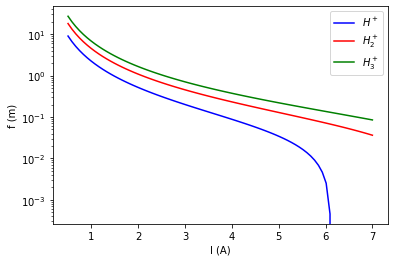

In [9]:
V=5e3
Is=np.linspace(0.5,7,80)
fsH=np.array([])
fsH2=np.array([])
fsH3=np.array([])
for i in Is:
    fsH=np.append(fsH,focus(i,mH,V))
plt.plot(Is,fsH,color='blue',label='$H^+$')
for i in Is:
    fsH2=np.append(fsH2,focus(i,mH2,V))
plt.plot(Is,fsH2,color='red',label='$H_2^+$')
for i in Is:
    fsH3=np.append(fsH3,focus(i,mH3,V))
plt.plot(Is,fsH3,color='green',label='$H_3^+$')
plt.yscale('log')
plt.xlabel('I (A)')
plt.ylabel('f (m)')
plt.legend()

### Radio del haz al llegar al pepperpot.

Habiendo calculado la distancia focal en funcion de la corriente del primer solenoide se puede calcular la posicion y tamaño de las proyecciones del grid en la pantalla de fosforo con las ecuaciones anteriormente mencionadas. Sin embargo, tambien se ha querido tener en cuenta como cambia el diametro del haz al llegar el pepperpot. 

Si el haz llega al primer solenoide con un radio $r_0$, sale de este con un radio $r_1=r_0\cos(\omega_L L/v_z)$, y llega al pepperpot con un radio $r_2=r_1(1-\frac{\omega_L \tan(\omega_L L/v_z)}{v_z}d1)$

In [10]:
def r2(r0,B,E,m,d):
    w=wL(B,m)
    vz=v(E,m)
    r1=r0*np.cos(w*L/vz)
    vr=r1*w*np.tan(w*L/vz)
    return np.abs(r1-vr/vz*d)

Utilizando $r_0=2cm$ y una corriente de 3A:

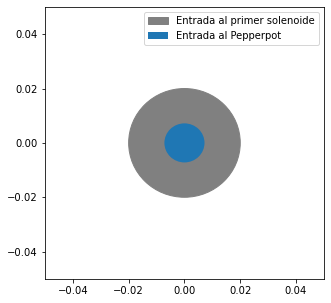

In [11]:
r0=0.02
I=3
rpepp=r2(r0,B(I),5e3*q,mH,0.1)
fig,ax=plt.subplots(1,1,figsize=(5,5))
circle0=patches.Circle((0,0),r0,color='grey',label='Entrada al primer solenoide')
ax.add_patch(circle0)
circle1=patches.Circle((0,0),rpepp,label='Entrada al Pepperpot')
ax.add_patch(circle1)
plt.xlim([-0.05,0.05])
plt.ylim([-0.05,0.05])
plt.legend()

### Proyecciones en la pantalla de fosforo:

Utilizando una sola especie:

In [12]:
I=3

(-30.0, 30.0)

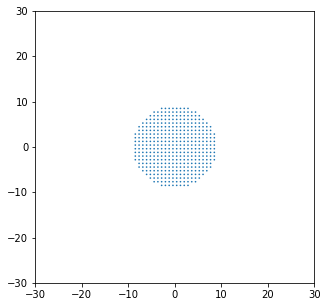

In [13]:
f=focus(I,mH,V)
factor=(1-d2/(f-d1))
fig,ax=plt.subplots(1,1,figsize=(5,5))
N=50
diam=0.5
Xs=np.linspace(-27.5,27.5,N)*factor
Ys=np.linspace(-27.5,27.5,N)*factor
r=r2(r0,B(I),V*q,mH,d1)
for x in Xs:
    for y in Ys:
        if (np.sqrt(x**2+y**2)<25*factor)and(np.sqrt(x**2+y**2)<1000*r):
            circle=patches.Circle((x,y),diam/2*factor)
            ax.add_patch(circle)
plt.xlim([-30,30])
plt.ylim([-30,30])

Teniendo más de una especie a la vez:

In [18]:
#I=1
I=3.3
I=4.6


(-30.0, 30.0)

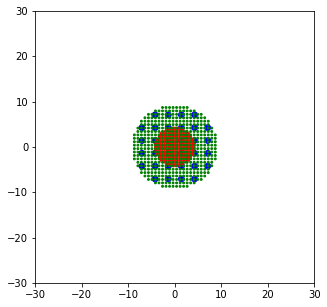

In [19]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
N=50
diam=0.5
m=mH
f=focus(I,m,V)
factor=(1-d2/(f-d1))
Xs=np.linspace(-27.5,27.5,N)
Ys=np.linspace(-27.5,27.5,N)
r=r2(r0,B(I),V*q,m,d1)

for x in Xs:
    for y in Ys:
        if (np.sqrt(x**2+y**2)<25)and(np.sqrt(x**2+y**2)<1000*r):
            circle=patches.Circle((x*factor,y*factor),diam/2*factor,color='blue')
            ax.add_patch(circle)
m=mH2       
f=focus(I,m,V)
factor=(1-d2/(f-d1))
Xs=np.linspace(-27.5,27.5,N)*factor
Ys=np.linspace(-27.5,27.5,N)*factor
r=r2(r0,B(I),V*q,m,d1)
for x in Xs:
    for y in Ys:
        if (np.sqrt(x**2+y**2)<25)and(np.sqrt(x**2+y**2)<1000*r):
            circle=patches.Circle((x*factor,y*factor),diam/2*factor,color='red')
            ax.add_patch(circle)
m=mH3
f=focus(I,m,V)
factor=(1-d2/(f-d1))
Xs=np.linspace(-27.5,27.5,N)*factor
Ys=np.linspace(-27.5,27.5,N)*factor
r=r2(r0,B(I),V*q,m,d1)
for x in Xs:
    for y in Ys:
        if (np.sqrt(x**2+y**2)<25*factor):
            if (np.sqrt(x**2+y**2)<25)and(np.sqrt(x**2+y**2)<1000*r):
                circle=patches.Circle((x*factor,y*factor),diam/2*factor,color='green')
                ax.add_patch(circle)
plt.xlim([-30,30])
plt.ylim([-30,30])